In [1]:
import pandas as pd
import numpy as np
import pandas_profiling

import swifter

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
import spacy
nlp_es = spacy.load("es", disable=['parser', 'tagger', 'ner'])
stops_es = stopwords.words("spanish")

import unidecode

import dask
import dask.distributed



import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from dask_ml.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from dask_ml.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score

import joblib
from joblib import dump, load

from dask.distributed import Client


NameError: name 'spacy' is not defined

In [145]:

def normalize(comment, lowercase, remove_stopwords, nlp, stops):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()  # get the lemma
        lemma = unidecode.unidecode(lemma)  # Remove accents
        lemma = re.sub(r'\d+', '',lemma)  # Remove numbers
        lemma = re.sub(r'_', '', lemma)
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)




In [3]:
c = Client()
c.cluster

In [30]:

df = pd.read_csv('train.csv', dtype = {'title':'object', 'label_quality':'category', 'language':'category', 'category':'category'})
df_test = pd.read_csv('test.csv', dtype={'title':'object','language':'category'})
df.sample(10)

,title,label_quality,language,category
8971758,Kit 5u 245/70 R16 Bridgestone Dueler H/t684iii...,unreliable,spanish,AUTOMOTIVE_TIRES
7641944,"Cortina Sicilia 3,00 X 2,70",unreliable,portuguese,INDOOR_CURTAINS_AND_BLINDS
4353975,Adesivo Protetor De Tanque Tank Pad Bomb Stick...,reliable,portuguese,VEHICLE_STICKERS
13274329,Cubiertas Run Flat 235/55/19,unreliable,spanish,AUTOMOTIVE_TIRES
4641338,Tapa De Consola Central Peugeot 207,unreliable,spanish,CAR_CENTER_CONSOLES
11778441,Kit C/6 Adoçante Linea Sucralose Pó C/50 Sachets,unreliable,portuguese,SWEETENERS
10982495,Equalizador Grafico Ge 400 Signus,unreliable,portuguese,EQUALIZERS
738864,Autitos Hot Wheels + Maletín Original,unreliable,spanish,DIECAST_VEHICLES
3822313,Short De Malla Verano 2017,unreliable,spanish,WOMEN_SWIMWEAR
8380495,Pileta Inflable 305 X 76 57270 Bestway Oferta ...,unreliable,spanish,POOL_INFLATABLES


In [40]:
df.head(5)

,title,label_quality,language,category
0,Hidrolavadora Lavor One 120 Bar 1700w Bomba A...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS


In [26]:
%time df.shape

CPU times: user 35 µs, sys: 104 µs, total: 139 µs
Wall time: 144 µs


(20000000, 4)

In [28]:
%time df.category.value_counts()

CPU times: user 2.83 s, sys: 342 ms, total: 3.17 s
Wall time: 3.26 s


PANTS                                   35973
COFFEE_MAKERS                           35104
BABY_CAR_SEATS                          34163
MUSICAL_KEYBOARDS                       33222
MATTRESSES                              32967
PUREBRED_DOGS                           32928
RANGES                                  32645
REFRIGERATORS                           32635
MOTORCYCLE_JACKETS                      32615
HAIR_CLIPPERS                           32372
SHORTS                                  31685
SUITCASES                               31580
MEMORY_CARDS                            31564
WINES                                   31399
ROLLER_SKATES                           31371
BABY_STROLLERS                          31353
SEWING_MACHINES                         31129
ELECTRIC_DRILLS                         30820
KITCHEN_SINKS                           30635
WALL_CLOCKS                             30600
FLASHLIGHTS                             29960
CV_JOINTS                         

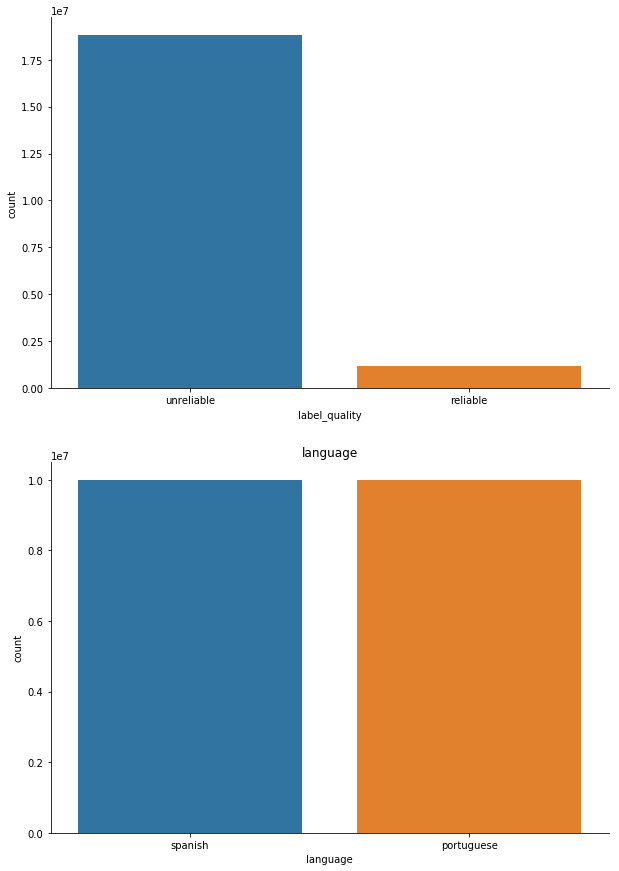

In [78]:
fig, ax = plt.subplots(2,1, figsize = (10,15))

for i, (col_name, col) in enumerate(df[['label_quality', 'language']].iteritems()):
    plt.title(col_name)
    sn.countplot(col, ax = ax[i]);
    sn.despine()
    

In [85]:
print(df['label_quality'].value_counts())
print(df['language'].value_counts())

unreliable    18815755
reliable       1184245
Name: label_quality, dtype: int64
spanish       10000000
portuguese    10000000
Name: language, dtype: int64


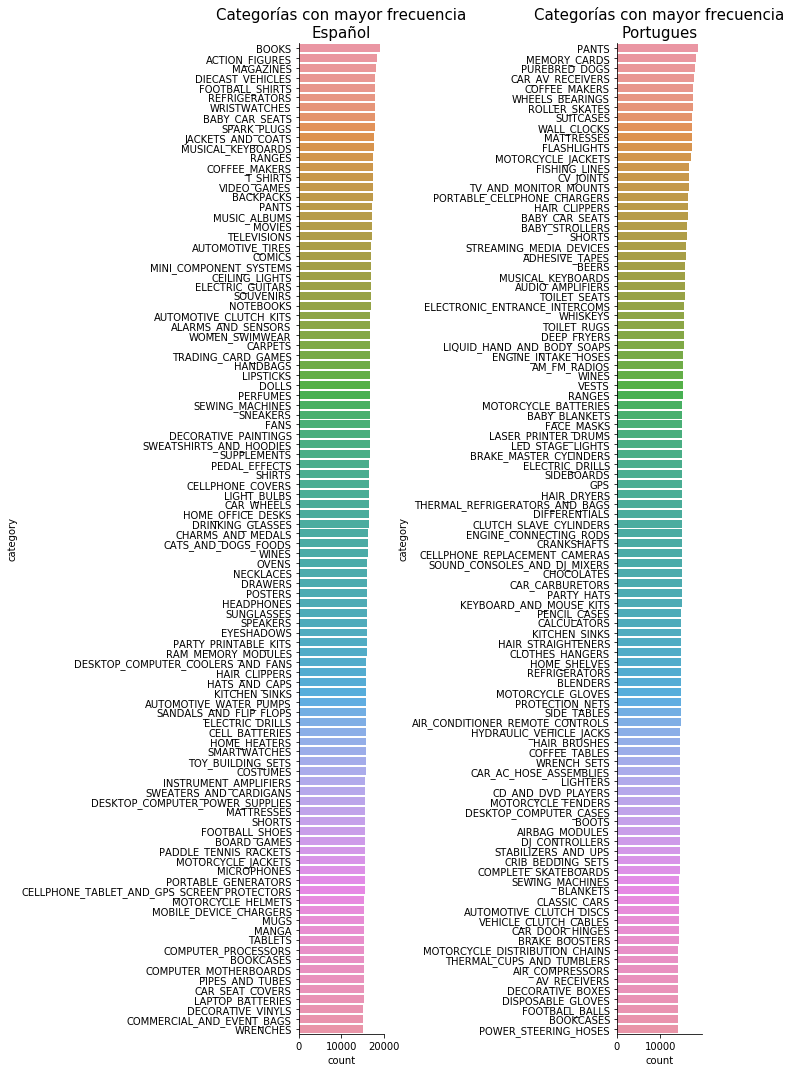

In [84]:
plt.rcParams['figure.figsize'] = (10,15)
#top_100_cats = df[df['category'].isin(df['category'].value_counts()[:100].index)]

top_cats_spanish = df[df['language'] == 'spanish']['category'].value_counts()[:100].index
top_cats_portuguese = df[df['language'] == 'portuguese']['category'].value_counts()[:100].index

plt.subplot(1,2,1)
plt.title('Categorías con mayor frecuencia\nEspañol', size = 15)
sn.countplot(y = 'category',
             order = top_cats_spanish,
             data=df[df['language'] == 'spanish']);

plt.subplot(1,2,2)
plt.title('Categorías con mayor frecuencia\nPortugues', size = 15)
sn.countplot(y = 'category',
             order = top_cats_portuguese,
             data=df[df['language'] == 'portuguese']);

sn.despine()
plt.tight_layout()

Categorías comunes entre las top 100 categorías más comunes para español y portugués:

In [81]:
common_cats = top_catcs_spanish.intersection(top_cats_portuguese)
print(common_cats)
print('\nCantidad de categorías en común: {}'.format(len(common_cats)))

Index(['REFRIGERATORS', 'BABY_CAR_SEATS', 'MUSICAL_KEYBOARDS', 'RANGES',
       'COFFEE_MAKERS', 'PANTS', 'SEWING_MACHINES', 'WINES', 'HAIR_CLIPPERS',
       'KITCHEN_SINKS', 'ELECTRIC_DRILLS', 'MATTRESSES', 'SHORTS',
       'MOTORCYCLE_JACKETS', 'BOOKCASES'],
      dtype='object')

Cantidad de categorías en común: 15


### Notas:
* **Problema:** Al parecer no hay un formato de redacción de clases único, hay clases en los que se reemplazo " " por "_" y otras en las que se conservó el espacio.
> **Solución:** Usar regex para estandarizar esto.
> Revisión: Esta todo Ok,al parecer miré mal, no hay ninguna clase que use " ".

* **Idea:** A partir de los nombres de las categorías, limpiar 'and' y 'or' y agregarlas como palabras a la matriz de frecuencias de términos.

* Va a haber que hacer stemming porque hay casos en que el título tiene palabras claves en plural, por ejemplo: 'conectores' --> 'conector'

* Usar spacy para el nlp


In [36]:
df.loc[df.category.str.contains('MOTOR'),'category'].value_counts()

MOTORCYCLE_JACKETS                                  32615
MOTORCYCLE_BATTERIES                                26966
MOTORCYCLE_GLOVES                                   26436
MOTORCYCLE_FENDERS                                  26408
MOTORCYCLE_DISTRIBUTION_CHAINS                      26275
MOTORCYCLE_HELMETS                                  24627
MOTORCYCLE_JERSEYS                                  22406
MOTORCYCLE_FAIRINGS                                 21964
MOTORCYCLE_HEADLIGHTS                               20129
MOTORCYCLE_TRANSMISSION_KITS                        20052
MOTORCYCLE_CRASH_BARS                               20018
MOTORCYCLE_CARBURETORS                              19843
MOTORCYCLE_CASES                                    19293
MOTORCYCLE_SEATS                                    19259
MOTORCYCLE_TRANSMISSION_CROWNS                      19102
GATE_MOTORS                                         18635
MOTORCYCLE_TURN_SIGNAL_LIGHTS                       18006
MOTORCYCLE_RAI

clases que contienen espacio '':

In [37]:
df.loc[df.category.str.contains(' '),'category'].value_counts()

Series([], Name: category, dtype: int64)

Clases que contienen '_'

In [38]:
df.loc[df.category.str.contains('_'),'category'].value_counts()

COFFEE_MAKERS                           35104
BABY_CAR_SEATS                          34163
MUSICAL_KEYBOARDS                       33222
PUREBRED_DOGS                           32928
MOTORCYCLE_JACKETS                      32615
HAIR_CLIPPERS                           32372
MEMORY_CARDS                            31564
ROLLER_SKATES                           31371
BABY_STROLLERS                          31353
SEWING_MACHINES                         31129
ELECTRIC_DRILLS                         30820
KITCHEN_SINKS                           30635
WALL_CLOCKS                             30600
CV_JOINTS                               29676
SWEATERS_AND_CARDIGANS                  29608
PORTABLE_GENERATORS                     29384
AIR_COMPRESSORS                         29259
TV_AND_MONITOR_MOUNTS                   29214
WHEELS_BEARINGS                         28920
LED_STAGE_LIGHTS                        28733
HAIR_STRAIGHTENERS                      28724
BABY_DIAPERS                      

Cantidad de categorias que comparten los conjuntos de train y test:

In [49]:
cats_train = df.category.unique().categories
cats_test = df.category.unique().categories

print('Cantidad de categorias que se encuentran en ambos conjuntos: {}'.format(len(cats_train.intersection(cats_test))))

Cantidad de categorias que se encuentran en ambos conjuntos: 1588


In [52]:
cats_train.unique()

Index(['ELECTRIC_PRESSURE_WASHERS', 'SOUND_CARDS', 'WASHING_MACHINES',
       'VEHICLE_BRAKE_DISCS', 'FALSE_EYELASHES', 'IRRIGATION_SPRINKLERS',
       'RACQUETS', 'CAMERA_TRIPODS', 'AUTOMOTIVE_AIR_FILTERS', 'LUNCHBOXES',
       ...
       'YOGURT_MAKERS', 'CERAMIC_KILNS', 'INDUSTRIAL_BLENDERS',
       'SCREEN_PRINTING_KITS', 'MARTIAL_ARTS_FOOT_GUARDS', 'FORCE_GAUGES',
       'QUEUE_STANCHIONS', 'HAMBURGER_FORMERS', 'MANUAL_TROLLEYS',
       'COMMERCIAL_POPCORN_MACHINES'],
      dtype='object', length=1588)

In [51]:
cats_test.unique()

Index(['ELECTRIC_PRESSURE_WASHERS', 'SOUND_CARDS', 'WASHING_MACHINES',
       'VEHICLE_BRAKE_DISCS', 'FALSE_EYELASHES', 'IRRIGATION_SPRINKLERS',
       'RACQUETS', 'CAMERA_TRIPODS', 'AUTOMOTIVE_AIR_FILTERS', 'LUNCHBOXES',
       ...
       'YOGURT_MAKERS', 'CERAMIC_KILNS', 'INDUSTRIAL_BLENDERS',
       'SCREEN_PRINTING_KITS', 'MARTIAL_ARTS_FOOT_GUARDS', 'FORCE_GAUGES',
       'QUEUE_STANCHIONS', 'HAMBURGER_FORMERS', 'MANUAL_TROLLEYS',
       'COMMERCIAL_POPCORN_MACHINES'],
      dtype='object', length=1588)

Están las mismas categorías en ambos conjuntos, por lo que se puede entrenar tranquilamente sobre train

## Stemming and preprocessing

In [5]:
# Run only once
#!python -m spacy download es

     |████████████████████████████████| 11.1MB 838kB/s eta 0:00:01    |████▋                           | 1.6MB 295kB/s eta 0:00:33     |█████████████████████████▉      | 9.0MB 670kB/s eta 0:00:04
  Stored in directory: /private/var/folders/5c/9v7l3rcs0jd4fvq5q95_xthr0000gn/T/pip-ephem-wheel-cache-i300demy/wheels/cc/ee/c4/68922955901918a9aaa82e828d4f7ee1ccfc861285277e79b7
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/Users/ignacio/anaconda3/lib/python3.7/site-packages/es_core_news_sm -->
/Users/ignacio/anaconda3/lib/python3.7/site-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [7]:
# Run only once
#!python -m spacy download pt

     |████████████████████████████████| 12.9MB 1.8MB/s eta 0:00:01
  Stored in directory: /private/var/folders/5c/9v7l3rcs0jd4fvq5q95_xthr0000gn/T/pip-ephem-wheel-cache-50cxpi50/wheels/a3/8f/c1/f036e3a7f1aa44fb06a534c6c4b1c2b773f101fdb1f163c08c
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/Users/ignacio/anaconda3/lib/python3.7/site-packages/pt_core_news_sm -->
/Users/ignacio/anaconda3/lib/python3.7/site-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [9]:
df.language.unique()

[spanish, portuguese]
Categories (2, object): [spanish, portuguese]

In [31]:
# Separate on language, remember to keep the language column
df_train_es = dask.delayed(df[df.language == 'spanish'])
df_train_pt = dask.delayed(df[df.language == 'portuguese'])
df_test_pt = dask.delayed(df_test[df_test.language == 'portuguese'])
df_test_es = dask.delayed(df_test[df_test.language == 'spanish'])

In [32]:
%%time
df_train_es, df_train_pt, df_test_pt, df_test_es = dask.compute(df_train_es, df_train_pt,
                                                                df_test_pt, df_test_es)

CPU times: user 1.85 ms, sys: 5.51 ms, total: 7.36 ms
Wall time: 68.1 ms


Se guardará cada subset para poder después ajustar modeos específicos a cada lenguaje

In [26]:
#df_train_es.to_csv('data/train_es.csv')
#df_train_pt.to_csv('data/train_pt.csv')
#df_test_pt.to_csv('data/test_pt.csv')
#df_test_es.to_csv('data/test_es.csv')
#

In [9]:
df_train_es = pd.read_csv('data/train_es.csv').drop('Unnamed: 0', axis = 1)
#df_train_pt = pd.read_csv('data/train_pt.csv')
df_test_es = pd.read_csv('data/test_es.csv').drop('Unnamed: 0', axis = 1)
#df_test_pt = pd.read_csv('data/test_pt.csv')


In [10]:
df_train_es.dtypes

title            object
label_quality    object
language         object
category         object
dtype: object

In [61]:
#nlp_es = spacy.load("es")
##nlp_pt = spacy.load("pt")
#
#nlp_es.remove_pipe('ner')
#nlp_es.max_length = 479575954
#
#doc_es = nlp_es(' '.join(df_train_es.title.values)) # Crea un objeto de spacy tipo nlp
##doc_pt = nlp_pt(df_train_pt.title)
#tokens_es = [t.orth_ for t in doc_es] # Crea una lista con las palabras del texto
##tokens_pt = [t.orth_ for t in doc_pt] 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ignacio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-be221334e518>", line 9, in <module>
    doc_es = nlp_es(' '.join(df_train_es.title.values)) # Crea un objeto de spacy tipo nlp
  File "/Users/ignacio/anaconda3/lib/python3.7/site-packages/spacy/language.py", line 394, in __call__
    doc = self.make_doc(text)
  File "/Users/ignacio/anaconda3/lib/python3.7/site-packages/spacy/language.py", line 418, in make_doc
    return self.tokenizer(text)
  File "tokenizer.pyx", line 112, in spacy.tokenizer.Tokenizer.__call__
  File "tokenizer.pyx", line 169, in spacy.tokenizer.Tokenizer._tokenize
  File "tokenizer.pyx", line 248, in spacy.tokenizer.Tokenizer._attach_tokens
  File "vocab.pyx", line 138, in spacy.vocab.Vocab.get
  File "vocab.pyx", line 167, in spacy.vocab.Vocab._new_lexeme
  File "/Users/ignacio/anacond

KeyboardInterrupt: 

In [15]:
%%time
## Español
df_train_es['Text_After_Clean'] = df_train_es.title[:1000].swifter.apply(normalize,
                                                             lowercase=True,
                                                             remove_stopwords=True,
                                                             nlp = nlp_es,
                                                             stops = stops_es)




CPU times: user 1.1 s, sys: 184 ms, total: 1.28 s
Wall time: 1.56 s


In [2]:
df_train_es.Text_After_Clean.dropna().sample(5, random_state = 5)

NameError: name 'df_train_es' is not defined

In [66]:
#df_train_es.to_csv('data/train_es_lema.csv')

In [156]:
## portugues
%%time
nlp_pt = spacy.load("pt", disable=['parser', 'tagger', 'ner'])
stops_pt = stopwords.words("portuguese")

df_train_pt['Text_After_Clean'] = df_train_pt.title.swifter.apply(normalize,
                                                             lowercase=True,
                                                             remove_stopwords=True,
                                                             nlp = nlp_pt)


KeyboardInterrupt: 

In [70]:
#df_train_pt.to_csv('data/train_pt_lema.csv')

No voy a usar Stemming porque en los títulos rara vez se ven sentencias con verbos.

## Term-Frecuency matrix

Voy a usar Count_vectorizer con un máximo de 1M de palabras, luego voy a aplicar Tf-Idf para filtrar palabras con poco peso.

In [17]:
frecuencies_descriptor_es = CountVectorizer(max_features = 1000000, strip_accents='unicode', max_df = .1, analyzer = 'word',
                                            token_pattern = '\w{3,9}')
frecuencies_mat_es = frecuencies_descriptor_es.fit_transform(df_train_es.Text_After_Clean.dropna())


* **Nota:** Acabo de ver que en los docs de dask se recomienda usar en algunos casos el descriptor `HashingExtractor` (se encuentra tanto en `sklearn` como `dask`) en lugar de `CountVectorizer`, por lo que después voy a probar con este.

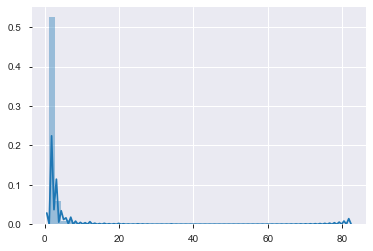

In [18]:
sn.distplot(frecuencies_mat_es.sum(axis = 0))

In [19]:
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True, norm = 'l1').fit(frecuencies_mat_es)

In [20]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=frecuencies_descriptor_es.get_feature_names(), columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights'], ascending= False)

,idf_weights
abarth,7.215608
newport,7.215608
morning,7.215608
moron,7.215608
morral,7.215608
morsa,7.215608
mosconi,7.215608
mosqueton,7.215608
motocargo,7.215608
motoculti,7.215608


{'whiskers': [<matplotlib.lines.Line2D at 0x1c39498ba8>,
 'caps': [<matplotlib.lines.Line2D at 0x1c39498eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c394985c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c394a49e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c394a4d68>],
 'means': []}

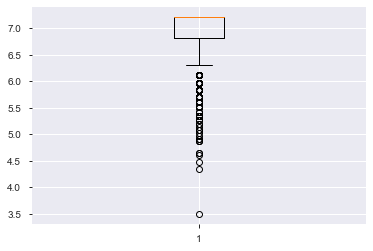

In [21]:
plt.boxplot(df_idf.idf_weights)

In [22]:
(df_idf.idf_weights > df_idf.idf_weights.quantile(.25)).value_counts()

True     2181
False     896
Name: idf_weights, dtype: int64

In [23]:
df_idf.shape

(3077, 1)

In [24]:
iqr = df_idf.idf_weights.quantile(.75) - df_idf.idf_weights.quantile(.25)

In [25]:
vocab_es = df_idf[df_idf.idf_weights >= df_idf.idf_weights.quantile(.25)-1.5*iqr].index #.sort_values(by ='idf_weights',ascending = False)

In [26]:
#cv_es = CountVectorizer(vocabulary=vocab_es, strip_accents='unicode', max_df = .1, analyzer = 'word',
#                                            token_pattern = '\w{3,9}')
#cv_es = cv_es.fit_transform(df_train_es.Text_After_Clean.dropna())
tfidf_es = TfidfVectorizer(vocabulary=vocab_es, strip_accents='unicode', max_df = .1, analyzer = 'word',
                                            token_pattern = '\w{3,9}', smooth_idf=True, use_idf=True, norm = 'l1')
tfidf_es = tfidf_es.fit_transform(df_train_es.Text_After_Clean.dropna())
tfidf_es.shape

(1000, 2910)

In [27]:
df_tfidf_es= pd.DataFrame(tfidf_es.todense())
df_tfidf_es['language'] = np.ones(shape = df_tfidf_es.shape[0])
df_tfidf_es.shape

(1000, 2911)

### Muestreo estratificado sobre category

Primero voy a ver la frecuencia de la clases minoritarias

In [60]:
df_train_es.category.value_counts()[-50:]

TONFAS                                  246
DENTAL_CURING_LIGHTS                    246
PIPE_CUTTERS                            246
WOOD_BURNING_MACHINES                   245
CACHACAS                                244
ELBOW_SUPPORTS                          244
STORE_SHOPPING_CARTS                    240
WASHING_AND_DRYER_MACHINE_COVERS        224
BOXING_SPEED_BAGS                       221
LENTILS                                 218
PLATE_COMPACTORS                        218
FAN_PROPELLERS                          212
INFLATABLE_SLIDES                       211
CONSTRUCTION_LIME_BAGS                  206
CHIPPER_SHREDDERS                       199
MANUAL_TROLLEYS                         186
TEMPORARY_TATTOOS                       186
MARTIAL_ARTS_CHEST_GUARDS               175
POOL_LADDERS                            173
ELECTRIC_BATHROOM_FAUCETS               169
CNC_MACHINING_CENTERS                   163
AQUARIUM_SKIMMERS                       156
WAITER_CALLING_SYSTEMS          

In [ ]:
df_tfidf_es

In [148]:
# undersampling con máximo 10**4 elementos de cada clase
undersamp_es = df_train_es.drop('Text_After_Clean', axis = 1).groupby('category', group_keys=False).apply(lambda x: x.sample(min(len(x), 10000)))


In [70]:
undersamp_es.category.value_counts()

SOUND_CONSOLES_AND_DJ_MIXERS                 10000
CALCULATORS                                  10000
MAKEUP_BRUSHES                               10000
SCREWS                                       10000
BABY_CAR_SEATS                               10000
CERAMIC_TILES                                10000
FANS                                         10000
SUNGLASSES                                   10000
MOTORCYCLE_DISTRIBUTION_CHAINS               10000
AUTOMOTIVE_TIRES                             10000
COLLECTIBLE_CANS_BOTTLES_AND_SODA_SIPHONS    10000
SURFACES_PROTECTIVE_PAINTS                   10000
HATS_AND_CAPS                                10000
TACTICAL_AND_SPORTING_KNIVES_AND_BLADES      10000
BACKPACKS                                    10000
FLOOD_LIGHTS                                 10000
MOTORCYCLE_HEADLIGHTS                        10000
CAR_TURN_SIGNAL_LIGHTS                       10000
FLASHLIGHTS                                  10000
CAR_LIGHT_BULBS                

In [149]:
undersamp_es.head()

,title,label_quality,language,category
2902960,Pack 2 Anteojos 3d Samsung P51002 Lentes A Pil...,unreliable,spanish,3D_GLASSES
7393808,Lente 3d Activo Sony Tdg-bt400a,unreliable,spanish,3D_GLASSES
5064292,Lente 3d Samsung Activo Ssg 5100gb,unreliable,spanish,3D_GLASSES
9362289,Nvidia 3d Vision,unreliable,spanish,3D_GLASSES
4296438,Lentes 3d Optoma Zf2300 Glasses En Dormusic,unreliable,spanish,3D_GLASSES


In [130]:
undersamp_es.shape

(8354505, 4)

In [150]:
undersamp_es_sample = undersamp_es.sample(10000, random_state = 1)

In [151]:
undersamp_es_sample['Text_After_Clean'] = undersamp_es_sample.title.swifter.apply(normalize,
                                                             lowercase=True,
                                                             remove_stopwords=True,
                                                             nlp = nlp_es,
                                                             stops = stops_es)



In [152]:
undersamp_es_sample.head()

,title,label_quality,language,category,Text_After_Clean
3406312,Exprimidor De Jugo Ultracomb Ex-2303 1.25lts N...,unreliable,spanish,SQUEEZERS,exprimidor jugo ultracomb ex- .lts naranja jug...
2916581,Lecto Grabadora De Cds / Dvds / Dual Layer Lg ...,unreliable,spanish,DVD_RECORDERS,lecto grabador cds / dvds / dual layer lg sata
5803248,Qualibest Cera Para Pisos Extra Negra Autobrillo,unreliable,spanish,HOUSEHOLD_CLEANING_WAXES,qualibest cera parir piso extra negro autobrillo
8360045,Motorcraft Jk6900a V - Cinturón,unreliable,spanish,SEAT_BELTS,motorcraft jka v - cinturon
4372739,Melzi 2.0 Control De Tablero 1284p Prusa I3 Co...,unreliable,spanish,3D_PRINTERS,melzi . control tablero p prusa i controlador ...


In [153]:
Y = undersamp_es_sample.language

undersamp_es_sample.drop(['title', 'label_quality', 'language'], axis = 1, inplace = True)
undersamp_es_sample.set_index('category', inplace = True)

Y.index = undersamp_es_sample.index

In [154]:
undersamp_es_sample.head()

,Text_After_Clean
category,
SQUEEZERS,exprimidor jugo ultracomb ex- .lts naranja jug...
DVD_RECORDERS,lecto grabador cds / dvds / dual layer lg sata
HOUSEHOLD_CLEANING_WAXES,qualibest cera parir piso extra negro autobrillo
SEAT_BELTS,motorcraft jka v - cinturon
3D_PRINTERS,melzi . control tablero p prusa i controlador ...


pandas.core.series.Series

In [92]:
## Load/store data

#undersamp_es.to_hdf('data/undersamp_es_10000.h5', key = 'data/')
#Y.to_hdf('data/Y_undersamp_es_10000.h5', key = 'data/')
#undersamp_es = pd.read_hdf('data/undersamp_es_10000.h5')
#Y = pd.read_hdf('data/Y_undersamp_es_10000.h5')

In [155]:
with joblib.parallel_backend("dask"):
    frecuencies_descriptor_es = CountVectorizer(max_features = 1000000, strip_accents='unicode', max_df = .1, analyzer = 'word',
                                            token_pattern = '\w{3,9}')
    frecuencies_mat_es = frecuencies_descriptor_es.fit_transform(undersamp_es_sample.Text_After_Clean)

    tfidf_mat_es=TfidfTransformer(smooth_idf=True, use_idf=True, norm = 'l1').fit(frecuencies_mat_es)

In [156]:
tfidf_mat_es.idf_

array([8.60100245, 9.51729319, 9.51729319, ..., 9.11182808, 9.51729319,
       9.51729319])

In [158]:
df_idf_es = pd.DataFrame(tfidf_mat_es.idf_, index=frecuencies_descriptor_es.get_feature_names(), columns=["idf_weights"])
# sort ascending
df_idf_es.sort_values(by=['idf_weights'], ascending= False)


,idf_weights
zyxel,9.517293
kitefoil,9.517293
kiosco,9.517293
kipor,9.517293
kirchner,9.517293
talla,9.517293
talkbox,9.517293
kite,9.517293
kitrics,9.517293
kingtons,9.517293


In [169]:
iqr = df_idf_es.idf_weights.quantile(.75) - df_idf_es.idf_weights.quantile(.25)

vocab_es = df_idf_es[df_idf_es.idf_weights >= df_idf_es.idf_weights.quantile(.25)-1.5*iqr].index #.sort_values(by ='idf_weights',ascending = False)

# Voy a guardar el vocabulario
#np.save('vocab_es.npy', vocab_es)

In [173]:
df_train_es['Text_After_Clean'] = df_train_es.title.swifter.apply(normalize,
                                                             lowercase=True,
                                                             remove_stopwords=True,
                                                             nlp = nlp_es,
                                                             stops = stops_es)

In [180]:
df_train_es.head()

,language,category,Text_After_Clean
0,spanish,ELECTRIC_PRESSURE_WASHERS,hidrolavadora lavor one bar w bombo aluminio i...
1,spanish,SOUND_CARDS,placa sonido - behringer umc
2,spanish,FALSE_EYELASHES,flash led pestana luminoso falso pestana parir...
3,spanish,LUNCHBOXES,gatito lunchera neoprene
4,spanish,BILL_COUNTERS,rosario contador billete uv / miligramo detect...


In [178]:
## 17/9
#df_train_es.drop(['title', 'label_quality'], axis = 1, inplace = True)
#df_train_es.to_hdf('data/df_train_es.h5', key = 'data/')

In [ ]:
#df_train.to_hdf('data/undersamp_es_10000.h5', key = 'data/')
#Y.to_hdf('data/Y_undersamp_es_10000.h5', key = 'data/')

In [184]:
tfidf_es = TfidfVectorizer(vocabulary=vocab_es, strip_accents='unicode', max_df = .1, analyzer = 'word',
                                            token_pattern = '\w{3,9}', smooth_idf=True, use_idf=True, norm = 'l1')
tfidf_es = tfidf_es.fit(df_train_es.Text_After_Clean)

AttributeError: 'TfidfVectorizer' object has no attribute 'shape'

* Luego de haber guardado el vocabulario, solo basta pasar todos los textos por la normalización, guardar ese df y crear el descriptor con el vocabulario listo.

In [185]:

#dump(tfidf_es, 'tfidf_trained_es.joblib')

['tfidf_trained_es.joblib']

In [187]:
df_train_es.shape

(10000000, 3)

In [188]:
tfidf_mat_es = tfidf_es.transform(df_train_es.Text_After_Clean)

In [189]:
tfidf_mat_es.shape

(10000000, 12424)

In [ ]:
pd.DataFrame(tfidf_mat_es).shape

In [37]:
Y = df_train_es.category[:1000]
Y[:10]

0      ELECTRIC_PRESSURE_WASHERS
1                    SOUND_CARDS
2                FALSE_EYELASHES
3                     LUNCHBOXES
4                  BILL_COUNTERS
5    PORTABLE_CELLPHONE_CHARGERS
6                   GARAGE_DOORS
7                   LABEL_MAKERS
8                   CAKE_TOPPERS
9                SCREEN_PRINTERS
Name: category, dtype: object

-------
# Modelamiento

In [41]:
np.logspace(-3,3,10)

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])

In [42]:
%%time

grid_params_svc = {'C':np.logspace(-3,3,10)}
grid_params
grid_svc = GridSearchCV(SVC(random_state = 11235813, gamma = 'auto'), param_grid = grid_params, n_jobs = -1, cv=5)

with joblib.parallel_backend("dask"):
    grid_svc.fit(df_tfidf_es, Y)

/Users/ignacio/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
distributed.scheduler - ERROR - 'ndarray-e0bd49439612fe03dd64fd6bab25470c'
Traceback (most recent call last):
  File "/Users/ignacio/anaconda3/lib/python3.7/site-packages/distributed/scheduler.py", line 1746, in update_graph
    resources=resources,
  File "/Users/ignacio/anaconda3/lib/python3.7/site-packages/distributed/diagnostics/graph_layout.py", line 50, in update_graph
    deps = dependencies[key]
KeyError: 'ndarray-e0bd49439612fe03dd64fd6bab25470c'
distributed.scheduler - ERROR - 'DataFrame-3255ff69edb9462e43210104c3085784'
Traceback (most recent call last):
  File "/Users/ignacio/anaconda3/lib/python3.7/site-packages/distributed/scheduler.py", line 1746, in update_graph
    resources=resources,


CPU times: user 24.3 s, sys: 1.54 s, total: 25.8 s
Wall time: 2min 41s


In [45]:
from sklearn.metrics import classification_report
print(classification_report(Y, grid_svc.predict(df_tfidf_es)))

                                              precision    recall  f1-score   support

                                 ABS_SENSORS       0.00      0.00      0.00         1
                            ACOUSTIC_GUITARS       0.00      0.00      0.00         1
                              ACTION_FIGURES       0.00      0.00      0.00         1
                              ADHESIVE_TAPES       0.00      0.00      0.00         2
                                     AIRBAGS       0.00      0.00      0.00         1
                                AIRSOFT_GUNS       0.00      0.00      0.00         2
                             AIR_COMPRESSORS       0.00      0.00      0.00         1
                              AIR_FRESHENERS       0.00      0.00      0.00         3
                          ALARMS_AND_SENSORS       0.00      0.00      0.00         2
                                ALARM_CLOCKS       0.00      0.00      0.00         1
                                 ALTERNATORS       0.

/Users/ignacio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----

In [10]:
import dask.dataframe as dd
import dask.distributed
import os


In [7]:
c = dask.distributed.Client()


In [8]:
dask_df = dd.read_csv('train.csv')
dask_df.head()

,title,label_quality,language,category
0,Hidrolavadora Lavor One 120 Bar 1700w Bomba A...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS
1,Placa De Sonido - Behringer Umc22,unreliable,spanish,SOUND_CARDS
2,Maquina De Lavar Electrolux 12 Kilos,unreliable,portuguese,WASHING_MACHINES
3,Par Disco De Freio Diant Vent Gol 8v 08/ Frema...,unreliable,portuguese,VEHICLE_BRAKE_DISCS
4,Flashes Led Pestañas Luminoso Falso Pestañas P...,unreliable,spanish,FALSE_EYELASHES


In [11]:
# Executed only once
#target = os.path.join('data', 'train.parquet')
#
#dask_df.categorize(columns=['label_quality', 'language', 'category']).to_parquet(target, has_nulls=False)

In [12]:
df_p = dd.read_parquet(target)
df_p.head()

,title,label_quality,language,category
0,Hidrolavadora Lavor One 120 Bar 1700w Bomba A...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS
1,Placa De Sonido - Behringer Umc22,unreliable,spanish,SOUND_CARDS
2,Maquina De Lavar Electrolux 12 Kilos,unreliable,portuguese,WASHING_MACHINES
3,Par Disco De Freio Diant Vent Gol 8v 08/ Frema...,unreliable,portuguese,VEHICLE_BRAKE_DISCS
4,Flashes Led Pestañas Luminoso Falso Pestañas P...,unreliable,spanish,FALSE_EYELASHES


In [25]:
%time dask.compute(df_p.shape)

CPU times: user 2.36 s, sys: 312 ms, total: 2.67 s
Wall time: 26 s


((20000000, 4),)

In [13]:
df_p.dtypes

title              object
label_quality    category
language         category
category         category
dtype: object

In [30]:
%time dask_df.category.value_counts().compute()

CPU times: user 2.93 s, sys: 356 ms, total: 3.29 s
Wall time: 36 s


PANTS                                   35973
COFFEE_MAKERS                           35104
BABY_CAR_SEATS                          34163
MUSICAL_KEYBOARDS                       33222
MATTRESSES                              32967
PUREBRED_DOGS                           32928
RANGES                                  32645
REFRIGERATORS                           32635
MOTORCYCLE_JACKETS                      32615
HAIR_CLIPPERS                           32372
SHORTS                                  31685
SUITCASES                               31580
MEMORY_CARDS                            31564
WINES                                   31399
ROLLER_SKATES                           31371
BABY_STROLLERS                          31353
SEWING_MACHINES                         31129
ELECTRIC_DRILLS                         30820
KITCHEN_SINKS                           30635
WALL_CLOCKS                             30600
FLASHLIGHTS                             29960
CV_JOINTS                         